In [1]:
import bs4
from bs4 import BeautifulSoup  
import pandas as pd
import scipy as sc
import numpy as np
import requests
import csv
import re 

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
def replace_missing_values(df, col_to_def_val_dict):
    newdf=df.fillna(value=col_to_def_val_dict)
    for col in df.select_dtypes(include=np.number):
        newdf[col] = df[col].fillna(df[col].median())
    for column in df.columns:
        newdf[column].fillna(newdf[column].mode()[0], inplace=True)
    return newdf



In [4]:
def outlier_iqr(df,col):
    Q1=np.percentile(df[col],25)
    Q3=np.percentile(df[col],75)
    IQR=Q3-Q1
    print(Q1,Q3,IQR)
    IQR_range=1.5*IQR
    row_outlier=df[(df[col]<Q1-IQR_range)|(df[col]>Q3+IQR_range)].index   
    for i in row_outlier:
        df.loc[i,col]=np.nan
    return df

In [5]:
pd.options.mode.chained_assignment = None
def outlier_detection_zscore_dist(df):
    df2=df.copy(deep=True)
    numeric=list()
    for col in df.select_dtypes(include=np.number):
        numeric.append(col)
    for n in numeric:
        z_score = (df[n] - df[n].mean()) / df[n].std(ddof=1)
        outliers = abs(z_score) > 3
        df2.loc[:,n][outliers]=np.nan
    
    return df2


In [6]:
def transfer_to_categorical(df, numeric_to_bin_value_dict): 
    labels = [1,2,3,4,5]
    for x in numeric_to_bin_value_dict:
        new_col=x+'_categotial'
        bins=numeric_to_bin_value_dict[x]
        df[new_col] = pd.cut(df[x], bins, labels=labels)
    return df

In [7]:
def cross_tabulation(df, col_name, other_col_name):
    return pd.crosstab(df[col_name],df[other_col_name],normalize='index')

In [8]:
def plot_cross_tabulation(df, col_names, other_col_name):
    n=len(col_names)
    fig, axes = plt.subplots(1,n, figsize=(20,5))
    for i in range(n):
        df_crosstab = cross_tabulation(df, col_names[i], other_col_name)
        df_crosstab.plot(kind='line',ax=axes[i])


In [9]:
import sklearn.preprocessing as preprocessing
def nornalize_col(df,col_name):
    float_array = df[col_name].values.astype(float).reshape(-1,1)
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_array = min_max_scaler.fit_transform(float_array)
    df[col_name]=scaled_array
    return df

In [10]:
df = pd.read_csv (r'Final_Data.csv',sep=",")
df.drop("Unnamed: 0",axis='columns', inplace=True)
df

,AQI,Temperature,Humidity,Wind,Pressure,City,State,Country
0,29.0,14,37,105,1015,Ashkasham,Badakhshan,Afghanistan
1,42.0,29,23,86,1005,BazareTashkan,Badakhshan,Afghanistan
2,42.0,22,26,52,1005,HafizMoghul,Badakhshan,Afghanistan
3,42.0,18,40,134,1013,KuranwaMunjan,Badakhshan,Afghanistan
4,42.0,31,21,85,1004,Mashhad,Badakhshan,Afghanistan
...,...,...,...,...,...,...,...,...
58628,46.0,20,25,83,1019,Beitbridge,MatabelelandSouth,Zimbabwe
58629,42.0,15,14,41,1021,Kwekwe,Midlands,Zimbabwe
58630,53.0,15,21,78,1021,Plumtree,MatabelelandSouth,Zimbabwe
58631,42.0,13,18,99,1022,Mvuma,Midlands,Zimbabwe


In [11]:
dfAVG = df.groupby(df.Country).mean()
dfAVG.drop("Temperature",axis='columns', inplace=True)
dfAVG.drop("Humidity",axis='columns', inplace=True)
dfAVG.drop("Wind",axis='columns', inplace=True)
dfAVG.drop("Pressure",axis='columns', inplace=True)
dfAVG

,AQI
Country,
Afghanistan,71.692661
AlandIslands,23.400000
Albania,24.657143
Algeria,65.333333
Andorra,33.000000
...,...
Venezuela,40.500000
Vietnam,52.556897
Yemen,154.000000


In [12]:
numeric_to_bin_value_dict = {'AQI': [0, 50, 100, 150, 300, 500 ]}
dfAVG = transfer_to_categorical(dfAVG, numeric_to_bin_value_dict)
dfAVG["AQI_categotial"]=dfAVG["AQI_categotial"].astype(str).astype(float)
dfAVG

,AQI,AQI_categotial
Country,,
Afghanistan,71.692661,2.0
AlandIslands,23.400000,1.0
Albania,24.657143,1.0
Algeria,65.333333,2.0
Andorra,33.000000,1.0
...,...,...
Venezuela,40.500000,1.0
Vietnam,52.556897,2.0
Yemen,154.000000,4.0


In [13]:
df_pop_factory = pd.read_csv (r'CountiesByVehicleAndMAnufacturing.csv',sep=",")
df_pop_factory.drop("Unnamed: 0",axis='columns', inplace=True)

In [14]:
df_pop_factory=df_pop_factory.merge(dfAVG, on='Country', how='left')
df_pop_factory.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 0 to 172
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Country                         173 non-null    object 
 1   Population                      173 non-null    float64
 2   Motor_vehicles_per_1k           173 non-null    float64
 3   Manufacturing_value_normalized  157 non-null    float64
 4   Total_Motor_vehicles            173 non-null    float64
 5   AQI                             141 non-null    float64
 6   AQI_categotial                  141 non-null    float64
dtypes: float64(6), object(1)
memory usage: 10.8+ KB


In [15]:
col_to_def_val = {'Country':'unknown'} 
df_pop_factory=replace_missing_values(df_pop_factory, col_to_def_val)
df_pop_factory

,Country,Population,Motor_vehicles_per_1k,Manufacturing_value_normalized,Total_Motor_vehicles,AQI,AQI_categotial
0,Afghanistan,38041754.0,47.0,0.000560,1787962.438,71.692661,2.0
1,Albania,2880917.0,167.0,0.000234,481113.139,24.657143,1.0
2,Algeria,43053054.0,153.0,0.011798,6587117.262,65.333333,2.0
3,Andorra,77142.0,1.0,0.000024,77.142,33.000000,1.0
4,Angola,31825295.0,32.0,0.002008,1018409.440,125.923077,3.0
...,...,...,...,...,...,...,...
168,Venezuela,28515829.0,145.0,0.014549,4134795.205,40.500000,1.0
169,Vietnam,96462106.0,23.0,0.009800,2218628.438,52.556897,2.0
170,Yemen,29161922.0,37.0,0.000924,1078991.114,154.000000,4.0
171,Zambia,17861030.0,23.0,0.000566,410803.690,47.031746,1.0


<AxesSubplot:>

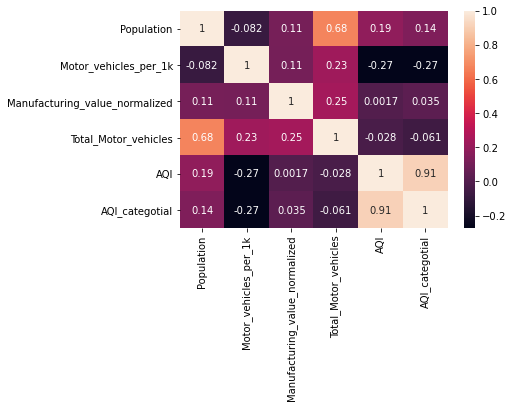

In [16]:

sns.heatmap(df_pop_factory.corr(), annot=True)

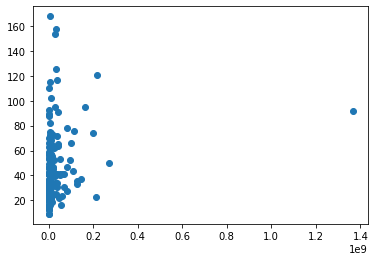

In [17]:
fig = plt.figure()

plt.scatter(df_pop_factory.Population, df_pop_factory.AQI)

plt.show()

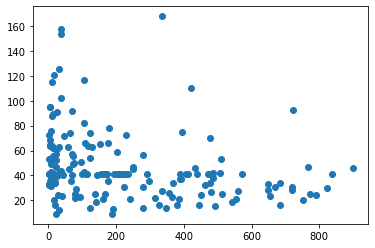

In [18]:
fig = plt.figure()

plt.scatter(df_pop_factory.Motor_vehicles_per_1k, df_pop_factory.AQI)

plt.show()

In [19]:
df_pop_forest = pd.read_csv (r'Population&Forest_Density.csv',sep=",")
df_pop_forest.drop("Unnamed: 0",axis='columns', inplace=True)

In [20]:
df_pop_forest=df_pop_forest.merge(dfAVG, on='Country', how='left')
df_pop_forest

,Country,Population_Density_km2,Forest_percentage,AQI,AQI_categotial
0,Afghanistan,1631,0.25,71.692661,2.0
1,Albania,7716,26.84,24.657143,1.0
2,Algeria,42000,1.70,65.333333,2.0
3,Andorra,160,34.19,33.000000,1.0
4,Angola,591040,47.41,125.923077,3.0
...,...,...,...,...,...
185,Venezuela,471378,51.68,40.500000,1.0
186,Vietnam,123000,37.14,52.556897,2.0
187,Yemen,4490,0.85,154.000000,4.0
188,Zambia,376309,50.00,47.031746,1.0


In [21]:

df_pop_forest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 190 non-null    object 
 1   Population_Density_km2  190 non-null    int64  
 2   Forest_percentage       190 non-null    float64
 3   AQI                     139 non-null    float64
 4   AQI_categotial          139 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 8.9+ KB


<AxesSubplot:>

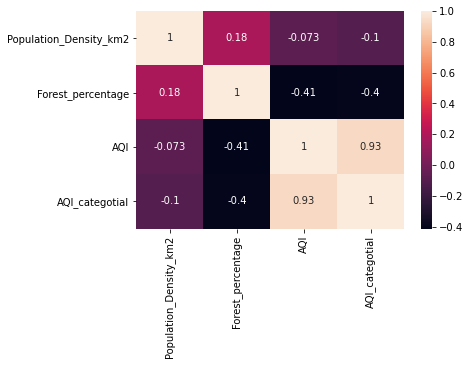

In [22]:
sns.heatmap(df_pop_forest.corr(), annot=True)

In [23]:
df_pop_forest.describe()

,Population_Density_km2,Forest_percentage,AQI,AQI_categotial
count,1.900000e+02,190.000000,139.000000,139.000000
mean,2.129149e+05,31.278474,47.981676,1.453237
std,9.940261e+05,24.243004,30.443989,0.683374
min,1.000000e+00,0.070000,9.000000,1.000000
25%,3.130250e+03,9.292500,25.426829,1.000000
50%,2.650000e+04,28.910000,40.500000,1.000000
75%,1.118312e+05,48.017500,62.864286,2.000000
max,1.200000e+07,90.200000,168.000000,4.000000


In [24]:
numeric_to_bin_value_dict = {'Forest_percentage':[0,20,40,60,80,100]}
#df_pop_forest = outlier_detection_zscore_dist(df_pop_forest)
col_to_def_val = {'Country':'unknown'} 
df_pop_forest=replace_missing_values(df_pop_forest, col_to_def_val)

df_pop_forest = transfer_to_categorical(df_pop_forest, numeric_to_bin_value_dict)


In [25]:
df_pop_forest

,Country,Population_Density_km2,Forest_percentage,AQI,AQI_categotial,Forest_percentage_categotial
0,Afghanistan,1631,0.25,71.692661,2.0,1
1,Albania,7716,26.84,24.657143,1.0,2
2,Algeria,42000,1.70,65.333333,2.0,1
3,Andorra,160,34.19,33.000000,1.0,2
4,Angola,591040,47.41,125.923077,3.0,3
...,...,...,...,...,...,...
185,Venezuela,471378,51.68,40.500000,1.0,3
186,Vietnam,123000,37.14,52.556897,2.0,2
187,Yemen,4490,0.85,154.000000,4.0,1
188,Zambia,376309,50.00,47.031746,1.0,3


In [26]:
df_pop_forest["Forest_percentage_categotial"]=df_pop_forest["Forest_percentage_categotial"].astype(str).astype(float)
df_pop_forest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 189
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       190 non-null    object 
 1   Population_Density_km2        190 non-null    int64  
 2   Forest_percentage             190 non-null    float64
 3   AQI                           190 non-null    float64
 4   AQI_categotial                190 non-null    float64
 5   Forest_percentage_categotial  190 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 10.4+ KB


<AxesSubplot:>

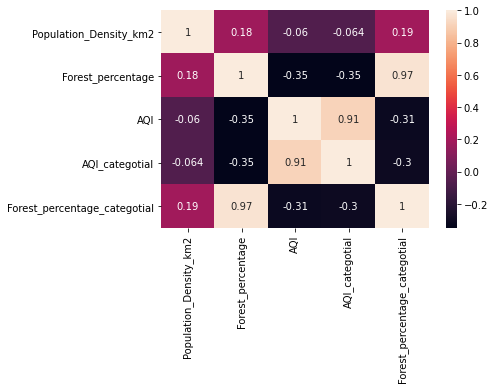

In [27]:
sns.heatmap(df_pop_forest.corr(), annot=True)

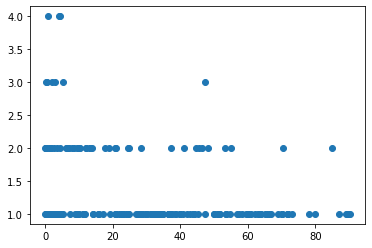

In [28]:
fig = plt.figure()

plt.scatter(df_pop_forest.Forest_percentage, df_pop_forest.AQI_categotial)

plt.show()

In [29]:
ct1=pd.crosstab(df_pop_forest.Forest_percentage,df_pop_forest.AQI_categotial )
ct1

AQI_categotial,1.0,2.0,3.0,4.0
Forest_percentage,,,,
0.07,1,1,0,0
0.12,0,1,0,0
0.25,0,1,0,0
0.26,2,0,1,0
0.34,0,1,0,0
...,...,...,...,...
87.15,1,0,0,0
89.12,1,0,0,0
89.45,1,0,0,0


Text(0, 0.5, 'Forest')

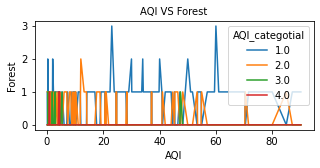

In [30]:
ct1.plot(kind='line', figsize=(5,2))

plt.title('AQI VS Forest', fontsize=10)
plt.xlabel('AQI')
plt.ylabel('Forest')

In [31]:
df1=pd.DataFrame(df_pop_forest,columns=['Country','Forest_percentage'])

In [32]:
df2=df.merge(df1,on='Country', how='left')
df2

,AQI,Temperature,Humidity,Wind,Pressure,City,State,Country,Forest_percentage
0,29.0,14,37,105,1015,Ashkasham,Badakhshan,Afghanistan,0.25
1,42.0,29,23,86,1005,BazareTashkan,Badakhshan,Afghanistan,0.25
2,42.0,22,26,52,1005,HafizMoghul,Badakhshan,Afghanistan,0.25
3,42.0,18,40,134,1013,KuranwaMunjan,Badakhshan,Afghanistan,0.25
4,42.0,31,21,85,1004,Mashhad,Badakhshan,Afghanistan,0.25
...,...,...,...,...,...,...,...,...,...
58628,46.0,20,25,83,1019,Beitbridge,MatabelelandSouth,Zimbabwe,66.35
58629,42.0,15,14,41,1021,Kwekwe,Midlands,Zimbabwe,66.35
58630,53.0,15,21,78,1021,Plumtree,MatabelelandSouth,Zimbabwe,66.35
58631,42.0,13,18,99,1022,Mvuma,Midlands,Zimbabwe,66.35


In [33]:
numeric_to_bin_value_dict = {'AQI': [0, 50, 100, 150, 300, 500 ]}
df2 = transfer_to_categorical(df2, numeric_to_bin_value_dict)
df2["AQI_categotial"]=df2["AQI_categotial"].astype(str).astype(float)
df2

,AQI,Temperature,Humidity,Wind,Pressure,City,State,Country,Forest_percentage,AQI_categotial
0,29.0,14,37,105,1015,Ashkasham,Badakhshan,Afghanistan,0.25,1.0
1,42.0,29,23,86,1005,BazareTashkan,Badakhshan,Afghanistan,0.25,1.0
2,42.0,22,26,52,1005,HafizMoghul,Badakhshan,Afghanistan,0.25,1.0
3,42.0,18,40,134,1013,KuranwaMunjan,Badakhshan,Afghanistan,0.25,1.0
4,42.0,31,21,85,1004,Mashhad,Badakhshan,Afghanistan,0.25,1.0
...,...,...,...,...,...,...,...,...,...,...
58628,46.0,20,25,83,1019,Beitbridge,MatabelelandSouth,Zimbabwe,66.35,1.0
58629,42.0,15,14,41,1021,Kwekwe,Midlands,Zimbabwe,66.35,1.0
58630,53.0,15,21,78,1021,Plumtree,MatabelelandSouth,Zimbabwe,66.35,2.0
58631,42.0,13,18,99,1022,Mvuma,Midlands,Zimbabwe,66.35,1.0


In [34]:
df_f=pd.DataFrame(df_pop_factory,columns=['Country','Population','Motor_vehicles_per_1k'])
df2=df2.merge(df_f,on='Country', how='left')
df2

,AQI,Temperature,Humidity,Wind,Pressure,City,State,Country,Forest_percentage,AQI_categotial,Population,Motor_vehicles_per_1k
0,29.0,14,37,105,1015,Ashkasham,Badakhshan,Afghanistan,0.25,1.0,38041754.0,47.0
1,42.0,29,23,86,1005,BazareTashkan,Badakhshan,Afghanistan,0.25,1.0,38041754.0,47.0
2,42.0,22,26,52,1005,HafizMoghul,Badakhshan,Afghanistan,0.25,1.0,38041754.0,47.0
3,42.0,18,40,134,1013,KuranwaMunjan,Badakhshan,Afghanistan,0.25,1.0,38041754.0,47.0
4,42.0,31,21,85,1004,Mashhad,Badakhshan,Afghanistan,0.25,1.0,38041754.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...
58628,46.0,20,25,83,1019,Beitbridge,MatabelelandSouth,Zimbabwe,66.35,1.0,14645468.0,60.0
58629,42.0,15,14,41,1021,Kwekwe,Midlands,Zimbabwe,66.35,1.0,14645468.0,60.0
58630,53.0,15,21,78,1021,Plumtree,MatabelelandSouth,Zimbabwe,66.35,2.0,14645468.0,60.0
58631,42.0,13,18,99,1022,Mvuma,Midlands,Zimbabwe,66.35,1.0,14645468.0,60.0


In [35]:
df2.to_csv("Final.csv")

In [36]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58633 entries, 0 to 58632
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AQI                    58589 non-null  float64
 1   Temperature            58633 non-null  int64  
 2   Humidity               58633 non-null  int64  
 3   Wind                   58633 non-null  int64  
 4   Pressure               58633 non-null  int64  
 5   City                   58633 non-null  object 
 6   State                  58633 non-null  object 
 7   Country                58633 non-null  object 
 8   Forest_percentage      39053 non-null  float64
 9   AQI_categotial         58373 non-null  float64
 10  Population             39715 non-null  float64
 11  Motor_vehicles_per_1k  39715 non-null  float64
dtypes: float64(5), int64(4), object(3)
memory usage: 5.8+ MB
